# Benchmark Training

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from summit import *
from multitask import *

import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2
from ord_schema.proto.reaction_pb2 import *
from ord_schema.message_helpers import find_submessages
from ord_schema import units

from rdkit import Chem
import rdkit.Chem.rdChemReactions as react
from pint import UnitRegistry

from pathlib import Path
from typing import Iterable
import pandas as pd

In [3]:
ureg = UnitRegistry()

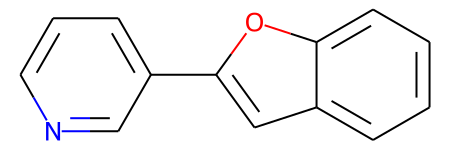

In [3]:
Chem.MolFromSmiles("C1(C2=CC(C=CC=C3)=C3O2)=CC=CN=C1")

## Load datasets

In [4]:
data_path = Path("../data")
baumgartner_suzuki_path = data_path / "baumgartner_suzuki"

In [5]:
# Load dataset message
baumgartner_datasets = [
    message_helpers.load_message(
        str(baumgartner_suzuki_path/ f"baumgartner_suzuki-minlp{i+1}-optimization.pb"), 
        dataset_pb2.Dataset
    )
    for i in range(2)
]

In [6]:
# Ensure dataset validates
valid_output = validations.validate_message(baumgartner_datasets[1])
valid_output.warnings

['Dataset.reactions[1].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[2].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[3].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[4].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[5].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[6].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, not fractions (9.999999747378752e-05 used)',
 'Dataset.reactions[7].outcomes[0].products[0].measurements[0].percentage: Percentage values are 0-100, no

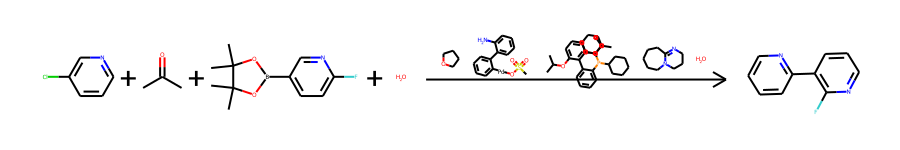

In [7]:
# Example reaction for visualization
rxn_smiles = message_helpers.get_reaction_smiles(
    baumgartner_datasets[0].reactions[0], 
    generate_if_missing=True
)
react.ReactionFromSmarts(rxn_smiles, useSmiles=True)

In [8]:
# Convert datasets to pandas dataframe
dfs = [
    suzuki_reaction_to_dataframe(
        baumgartner_datasets[i].reactions, 
    )
    for i in range(2)
]

In [9]:
dfs[0].columns

Index(['reagent', 'reagent_concentration (M)', 'solvent', 'nucleophile_smiles',
       'nucleophile_concentration (M)', 'electrophile_smiles',
       'electrophile_concentration (M)', 'pre_catalyst_smiles',
       'catalyst_concentration (M)', 'ligand_smiles', 'ligand_ratio',
       'temperature (deg C)', 'time (min)', 'yld (percentage)'],
      dtype='object')

Table Columns:
- [x] Electrophile / Nucleophile SMILES
- [x] Reactant concentrations or equivalents
- [x] Pre-catalyst
- [x] Ligand
- [x] Temperature
- [x] Reaction Time
- [x] Yield

In [10]:
# Remove units from column names
no_units = lambda s: s.split(" ")[0]
dfs = [df.rename(columns=no_units) for df in dfs]

In [22]:
continuous = [v.name for v in domain.input_variables if v.variable_type=="continuous"]
for df in dfs:
    for c in continuous:
        df[c] = df[c].astype(float)

## Domain

In [60]:
domain = Domain()

# Decision variables
domain += ContinuousVariable(
    name="electrophile_concentration",
    description="Concentration of electrophile in molar",
    bounds=[0,2]
)
domain += ContinuousVariable(
    name="nucleophile_concentration",
    description="Concentration of nucleophile in molar",
    bounds=[0,2]
)

domain += CategoricalVariable(
    name="pre_catalyst_smiles",
    description="SMILES of the pre-catalyst",
    levels=dfs[0]["pre_catalyst_smiles"].unique().tolist()
)

domain += ContinuousVariable(
    name="catalyst_concentration",
    description="Concentration of pre_catalyst in molar",
    bounds=[0,2]
)

domain += CategoricalVariable(
    name="ligand_smiles",
    description="SMILES of the ligand",
    levels=dfs[0]["ligand_smiles"].unique().tolist()
)
domain += ContinuousVariable(
    name="ligand_ratio",
    description="Ratio of pre-catalyst to ligand",
    bounds=[0,5]
)

# Objectives
domain += ContinuousVariable(
    name="yld",
    description="Reaction yield",
    bounds=[0,100],
    is_objective=True
)
domain

Name,Type,Description,Values
electrophile_concentration,"continuous, input",Concentration of electrophile in molar,"[0,2]"
nucleophile_concentration,"continuous, input",Concentration of nucleophile in molar,"[0,2]"
pre_catalyst_smiles,"categorical, input",SMILES of the pre-catalyst,2 levels
catalyst_concentration,"continuous, input",Concentration of pre_catalyst in molar,"[0,2]"
ligand_smiles,"categorical, input",SMILES of the ligand,7 levels
ligand_ratio,"continuous, input",Ratio of pre-catalyst to ligand,"[0,5]"
yld,"continuous, maximize objective",Reaction yield,"[0,100]"


## Train Benchmarking

In [28]:
dfs[0]["electrophile_concentration"].describe()

count    95.000000
mean      0.088537
std       0.028030
min       0.076462
25%       0.076463
50%       0.076464
75%       0.076466
max       0.152933
Name: electrophile_concentration, dtype: float64

In [61]:
dfs[0][[v.name for v in domain.input_variables if v.variable_type=="continuous"]].describe()

,electrophile_concentration,nucleophile_concentration,catalyst_concentration,ligand_ratio
count,95.000000,95.000000,95.000000,95.0
mean,0.088537,0.133771,0.001623,1.0
std,0.028030,0.042342,0.000828,0.0
min,0.076462,0.115517,0.000384,1.0
25%,0.076463,0.115518,0.000867,1.0
50%,0.076464,0.115520,0.001912,1.0
75%,0.076466,0.115522,0.001922,1.0
max,0.152933,0.231047,0.003857,1.0


In [ ]:
emul = ExperimentalEmulator("baumgartner_suzuki", domain=domain, dataset=dfs[0])
emul.train(cv_folds=5, max_epochs=1000, verbose=1)

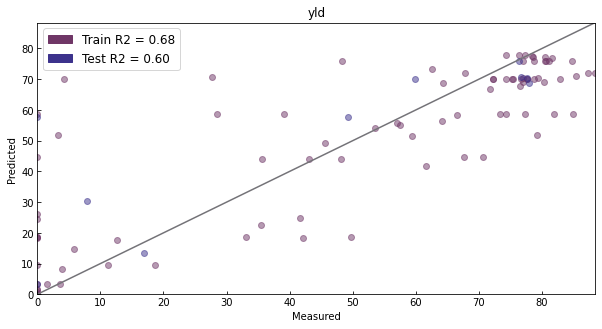

In [65]:
fig, ax = emul.parity_plot(include_test=True)